In [1]:
from google.colab import drive
drive.mount('/content/drive')


import os

import torch
os.chdir('/content/drive/MyDrive/ImitationLearning/Invariant-Causal-Imitation-Learning-main/')


Mounted at /content/drive


# load

In [2]:
!pip install mpi4py 
!pip install box2d-py
!pip install box2d 
!pip3 install gym[Box_2D] 
!pip install gym==0.17.2 -qqq
!pip install numpy~=1.18.2 -qqq
!pip install pandas~=1.0.4 -qqq
!pip install PyYAML~=5.4.1 -qqq
!pip install scikit-learn~=0.22.2 -qqq
!pip install scipy~=1.1.0 -qqq
!pip install stable-baselines~=2.10.1 -qqq
!pip install tensorflow~=1.15.0 -qqq
!pip install torch>=1.6.0 -qqq
!pip install tqdm~=4.32.1 -qqq


     |████████████████████████████████| 2.5 MB 7.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185293 sha256=9d1234a48dd1caa205e94e5154059e82e17d56b2debc80da04502b8b3c488001
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py
     |████████████████████████████████| 448 kB 9.1 MB/s 
     |████████████████████████████████| 1.3 MB 6.9 MB/s 
     |████████████████████████████████| 1.6 MB 8.3 MB/s 
     |████████████████████████████████| 20.1 MB 11.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requir

#config

In [3]:

config = {
    "ENV": "CartPole-v1",
    "ALG": "BCIRMStudent_Apr17",
    "NUM_TRAJS_GIVEN": 20, #
    "NUM_TRAINING_ENVS": 2,
    "NOISE_DIM": 4,
    "REP_SIZE": 16,
    "TRAJ_SHIFT": 20, # 20,
    "SAMPLING_RATE": 5,
    "NUM_STEPS_TRAIN": 10000,
    "NUM_TRAJS_VALID": 100,
    "NUM_REPETITIONS": 15,
    "BATCH_SIZE": 64,
    "MLP_WIDTHS": 64,
    "ADAM_ALPHA": 1e-3,
    "SGLD_BUFFER_SIZE": 10000,
    "SGLD_LEARN_RATE": 0.01,
    "SGLD_NOISE_COEF": 0.01,
    "SGLD_NUM_STEPS": 100,
    "SGLD_REINIT_FREQ": 0.05,
    "NUM_STEPS_TRAIN_ENERGY_MODEL": 1000,
    #"NUM_STEPS_TRAIN_VAE_MODEL": 20000,
    'TRIAL': 0
}


#config['ENV'] = "LunarLander-v2"
config['ENV'] = "CartPole-v1"

#config['METHOD'] = "BCIRM"
config['METHOD'] = "iVAE_IRM"





if config['METHOD'] == 'BCIRM':
    config['l2_regularizer_weight'] = 0.001
    config['penalty_weight'] = 10000
    config['penalty_anneal_iters'] = 2500
elif config['METHOD'] == "iVAE_IRM":
    config["NUM_STEPS_TRAIN_VAE_MODEL"] = 10000
    config['PHASE2_SAMPLES'] = 50000
    #config['LATENT_DIM'] = config["REP_SIZE"]



#testing/il

In [5]:
import argparse
import os
import pickle

import gym
import numpy as np
import pandas as pd
import yaml
import numpy as np

from testing.paths import get_model_path, get_trajs_path  # pylint: disable=reimported

from contrib.energy_model import EnergyModel
from contrib.env_wrapper import EnvWrapper, get_test_mult_factors
from network import EnvDiscriminator
from network import FeaturesDecoder
from network import FeaturesEncoder
from network import MineNetwork 
from network import ObservationsDecoder
from network import StudentNetwork


from student import ICILStudent, BCStudent, BCIRMStudent, iVAE_IRMStudent 
from testing.train_utils import fill_buffer, make_agent, save_results
from vae.ivae_wrapper import VAE_wrapper
  


# make student

In [ ]:


# pylint: disable=redefined-outer-name
def make_student(run_seed, config):
    env = gym.make(config["ENV"])
    trajs_path = get_trajs_path(config["ENV"], "student_" + config["ALG"], env_id="student", run_seed=run_seed)
    model_path = get_model_path(config["ENV"], "student_" + config["ALG"], run_seed=run_seed)

    state_dim = env.observation_space.shape[0] + config["NOISE_DIM"]
    action_dim = env.action_space.n
    num_training_envs = config["NUM_TRAINING_ENVS"]

    # run_seed = run_seed
    batch_size = config["BATCH_SIZE"]
    teacher = make_agent(config["ENV"], config["EXPERT_ALG"], config["NUM_TRAINING_ENVS"])
    teacher.load_pretrained()

    buffer = fill_buffer(
        trajs_path=teacher.trajs_paths,
        batch_size=batch_size,
        run_seed=run_seed,
        traj_shift=config["TRAJ_SHIFT"],
        buffer_size_in_trajs=config["NUM_TRAJS_GIVEN"],
        sampling_rate=config["SAMPLING_RATE"],
    )

    if buffer.total_size < batch_size:
        batch_size = buffer.total_size



    ##########################      COMMON      ##########################

    print("state_dim", state_dim)

    causal_features_encoder = FeaturesEncoder(
        input_size=state_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"]
    )

    policy_network = StudentNetwork(in_dim=config["REP_SIZE"], out_dim=action_dim, width=config["MLP_WIDTHS"])

    #print("config method = ", config['METHOD'])


    ##########################       BC       #######################

    if config['METHOD'] == 'BC':

        return BCStudent(
            env=env,
            trajs_paths=trajs_path,
            model_path=model_path,
            num_training_envs=num_training_envs,
            teacher=teacher,
            causal_features_encoder=causal_features_encoder,
            policy_network=policy_network,
            buffer=buffer,
            adam_alpha=config["ADAM_ALPHA"],
            config = config
        )


    ##########################       BC IRM       #######################


    elif config['METHOD'] == 'BCIRM':

        return BCIRMStudent(
            env=env,
            trajs_paths=trajs_path,
            model_path=model_path,
            num_training_envs=num_training_envs,
            teacher=teacher,
            causal_features_encoder=causal_features_encoder,
            policy_network=policy_network,
            buffer=buffer,
            adam_alpha=config["ADAM_ALPHA"],
            config = config
        )



    ##########################       iVAE IRM       #######################

    elif config['METHOD'] == 'iVAE_IRM':

        config['LATENT_DIM'] = state_dim 

        vae_wrapper =  VAE_wrapper(buffer, data_dim = state_dim, action_dim = action_dim, env_dim = config['NUM_TRAINING_ENVS'], latent_dim = config['LATENT_DIM'], use_e = True)
        vae_wrapper.train(num_updates=config["NUM_STEPS_TRAIN_VAE_MODEL"])
        #vae_wrapper.start_phase2(n_samples = config['PHASE2_SAMPLES'])
        vae_wrapper.pa_list = [0,1,2,3,4,5,6,7]
        

        causal_features_encoder = FeaturesEncoder(
            input_size=config["LATENT_DIM"], representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"] )

        policy_network = StudentNetwork(in_dim=config["REP_SIZE"], out_dim=action_dim, width=config["MLP_WIDTHS"])

        phase3_obs_to_latent_encoder = FeaturesEncoder(
            input_size=state_dim, representation_size=config["LATENT_DIM"], width=config["MLP_WIDTHS"] )
        
        #causal_features_encoder = FeaturesEncoder(
        #            input_size=state_dim, representation_size = len(vae_wrapper.pa_list), width=config["MLP_WIDTHS"])

        #policy_network = StudentNetwork(in_dim = config['LATENT_DIM'], out_dim=action_dim, width=config["MLP_WIDTHS"])

        
        return iVAE_IRMStudent(
            env=env,
            vae_wrapper = vae_wrapper,
            trajs_paths=trajs_path,
            model_path=model_path,
            num_training_envs=num_training_envs,
            teacher=teacher,
            phase3_obs_to_latent_encoder = phase3_obs_to_latent_encoder,
            causal_features_encoder=causal_features_encoder,
            policy_network=policy_network,
            buffer=buffer,
            adam_alpha=config["ADAM_ALPHA"],
            config = config
        )
        


    ##########################       ICIL        #######################

    elif config['METHOD'] == 'ICIL':
        energy_model = EnergyModel(
            in_dim=state_dim,
            width=config["MLP_WIDTHS"],
            batch_size=batch_size,
            adam_alpha=config["ADAM_ALPHA"],
            buffer=buffer,
            sgld_buffer_size=config["SGLD_BUFFER_SIZE"],
            sgld_learn_rate=config["SGLD_LEARN_RATE"],
            sgld_noise_coef=config["SGLD_NOISE_COEF"],
            sgld_num_steps=config["SGLD_NUM_STEPS"],
            sgld_reinit_freq=config["SGLD_REINIT_FREQ"],
        )
        energy_model.train(num_updates=config["NUM_STEPS_TRAIN_ENERGY_MODEL"])

        causal_features_decoder = FeaturesDecoder(action_size=action_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"])

        observations_decoder = ObservationsDecoder(representation_size=config["REP_SIZE"], out_size=state_dim, width=config["MLP_WIDTHS"] )

        env_discriminator = EnvDiscriminator(representation_size=config["REP_SIZE"], num_envs=config["NUM_TRAINING_ENVS"], width=config["MLP_WIDTHS"])

        noise_features_encoders = [FeaturesEncoder(input_size=state_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"])  
            for i in range(num_training_envs)]
        
        noise_features_decoders = [FeaturesDecoder(action_size=action_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"])
            for i in range(num_training_envs)]

        mine_network = MineNetwork(x_dim=config["REP_SIZE"], z_dim=config["REP_SIZE"], width=config["MLP_WIDTHS"])

        return ICILStudent(
            env=env,
            trajs_paths=trajs_path,
            model_path=model_path,
            num_training_envs=num_training_envs,
            teacher=teacher,
            causal_features_encoder=causal_features_encoder,
            noise_features_encoders=noise_features_encoders,
            causal_features_decoder=causal_features_decoder,
            noise_features_decoders=noise_features_decoders,
            observations_decoder=observations_decoder,
            env_discriminator=env_discriminator,
            policy_network=policy_network,
            energy_model=energy_model,
            mine_network=mine_network,
            buffer=buffer,
            adam_alpha=config["ADAM_ALPHA"],
            config = config
        )


def init_arg():
    parser = argparse.ArgumentParser()
    parser.add_argument("--env_name", default="CartPole-v1")
    parser.add_argument("--num_trajectories", default=20, type=int)
    parser.add_argument("--trial", default=0, type=int)
    return parser.parse_args()


#10 Trails -- BCIRM

In [ ]:
config['METHOD'] = "BCIRM"

for traj_num in [100]:
    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num

    config['ALG'] = "FINAL_BCIRMStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "BCIRMStudent_Apr19_replicatedata"
    #config['METHOD'] = "BCIRM"
    #config['METHOD'] = "ICIL"
    #config["NUM_TRAJS_GIVEN"] = 50
    #config["TRAJ_SHIFT"] = 50
    #config['ENV'] == "CartPole-v1"
    ###############.  settings   ###############


    if config['METHOD'] == 'BCIRM':
        config['l2_regularizer_weight'] = 0.001
        config['penalty_weight'] = 10000
        config['penalty_anneal_iters'] = 5000

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))
            student = make_student(run_seed, config)
            student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1
            )

            env_wrapper_out_of_sample.noise = 0

            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample
            )

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))
    print("ALL RESULTS TRAIL:" , all_results_trail)




Config: {'ENV': 'CartPole-v1', 'ALG': 'FINAL_BCIRMStudent_replicatedata_trajnum100', 'NUM_TRAJS_GIVEN': 100, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 8, 'TRAJ_SHIFT': 100, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 15, 'BATCH_SIZE': 64, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'METHOD': 'BCIRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 20000, 'PHASE2_SAMPLES': 50000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10000, 'penalty_anneal_iters': 5000, 'EXPERT_ALG': 'dqn'}
Trial number 0
config method =  BCIRM
config env =  CartPole-v1
Run 1 out of 15
state_dim 8
200 tensor(0.3100, device='cuda:0', grad_fn=<AddBackward0>)
400 tensor(0.3399, device='cuda:0', grad_fn=<AddBackward0>)
600 tensor(0.4541, device='cuda:0', grad_fn=<AddBackward0>)
800 tensor(0.3309, device='cuda

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


IndexError: ignored

#10 Trails -- BC

In [ ]:
config['METHOD'] = "BC"

for traj_num in [5]:
    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "test2_BCStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "BCStudent_Apr19_replicatedata"
    #config['METHOD'] = "BC"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"
    #config["NUM_TRAJS_GIVEN"] = 20
    #config["TRAJ_SHIFT"] = 20
    ###############.  settings   ###############



    if config['METHOD'] == 'BCIRM':
        config['l2_regularizer_weight'] = 0.001
        config['penalty_weight'] = 10000
        config['penalty_anneal_iters'] = 100

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))
            student = make_student(run_seed, config)
            student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1
            )
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample
            )

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

Config: {'ENV': 'CartPole-v1', 'ALG': 'test2_BCStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 15, 'BATCH_SIZE': 64, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'METHOD': 'BC', 'NUM_STEPS_TRAIN_VAE_MODEL': 10000, 'PHASE2_SAMPLES': 50000, 'EXPERT_ALG': 'dqn'}
Trial number 0
config method =  BC
config env =  CartPole-v1
Run 1 out of 15
state_dim 8
epoch 9000/10000, policy loss 0.3081601858139038	epoch 0/100 return: 171.0epoch 10/100 return: 143.0epoch 20/100 return: 170.0epoch 30/100 return: 145.0epoch 40/100 return: 152.0epoch 50/100 return: 272.0epoch 60/100 return: 140.0epoch 70/100 return: 139.0epoch 80/100 return: 152.0epoch 90/100 return: 500.0####

KeyboardInterrupt: ignored

#10 Trails -- ICIL

In [ ]:
config['METHOD'] = "ICIL"

for traj_num in [8, 16, 32, 64, 100]:
    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "FINAL_ICILStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############



    if config['METHOD'] == 'BCIRM':
        config['l2_regularizer_weight'] = 0.001
        config['penalty_weight'] = 10000
        config['penalty_anneal_iters'] = 100

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))
            student = make_student(run_seed, config)
            student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1
            )
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample
            )

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

#10 Trails -- iVAE IRM

In [ ]:
config["MLP_WIDTHS"]

64

In [ ]:
self.policy_network

StudentNetwork(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [ ]:
samples = self.buffer.sample()
self.vae_wrapper.predict_latent(samples).detach().shape

torch.Size([64, 8])

In [ ]:
import torch.optim as optim
import torch.nn as nn
import copy

num_updates = 10000

self = student
policy_network = StudentNetwork(in_dim=self.vae_wrapper.state_dim*2, out_dim=self.vae_wrapper.action_dim, width=config["MLP_WIDTHS"])
self.policy_network = policy_network.to(self.device)
causal_features_encoder = FeaturesEncoder(input_size=self.vae_wrapper.state_dim, representation_size=self.vae_wrapper.state_dim*2, width=config["MLP_WIDTHS"])
self.causal_features_encoder = causal_features_encoder.to(self.device)
self.policy_opt = optim.Adam( list(self.causal_features_encoder.parameters()) + list(self.policy_network.parameters()), lr=self.adam_alpha)
#self.policy_opt = optim.Adam(  list(self.policy_network.parameters()), lr=self.adam_alpha)
#student.train(num_updates=config["NUM_STEPS_TRAIN"])

for update_index in (range(10000)):

    samples = self.buffer.sample()

    state = torch.FloatTensor(samples["state"]).to(self.device)
    action = torch.LongTensor(samples["action"]).to(self.device)
    
    latents = self.vae_wrapper.predict_latent(samples).detach()
    
    # phase 3. obs_to_latent  MSE loss
    obs_to_latent_rep = self.phase3_obs_to_latent_encoder(state)
    mse_loss = nn.MSELoss()(obs_to_latent_rep, latents)
    
    
    # phase 1. policy loss
    masked_latents = copy.deepcopy(latents)
    #if len(self.masked_states)>0:
    #    masked_latents[:, self.masked_states] = 0
    
    #causal_rep = self.causal_features_encoder(masked_latents)  # need this encoder: S -> rep
    causal_rep = self.causal_features_encoder(state)  # need this encoder: S -> rep
    
    qvalues = self.policy_network(causal_rep) # need this encoder:  rep -> A
    #qvalues = self.policy_network(latents) # need this encoder:  rep -> A
    
    ce_loss = nn.CrossEntropyLoss()(qvalues, action)
    policy_loss = ce_loss

    #policy_loss, obs_to_latent_loss = self._update_networks()
    
    if update_index % 1000 == 0:
        #print(update_index)
        print('\repoch {}/{}, policy loss {} \t'.format(update_index, num_updates, policy_loss.detach() ), end="")
        





epoch 9000/10000, policy loss 0.6885848045349121 	

# BC

In [ ]:
self.policy_network

StudentNetwork(
  (layers): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [ ]:
self = student 
self.vae_wrapper.start_phase2(n_samples = config['PHASE2_SAMPLES'])


***** Starts Phase 2 *****
0 and 1 are independent with pval_d=0.725503302087839 and pval_i=0.9934113699655196
0 and 2 are independent with pval_d=0.05422847001080807 and pval_i=0.9940972743402244
0 and 3 are DEPENDENT with pval_d=1.0632048115910987e-08 and pval_i=6.853982399393497e-10
0 and 4 are independent with pval_d=0.41034463568428037 and pval_i=0.9856595075408379
0 and 5 are DEPENDENT with pval_d=0.33256319318241656 and pval_i=8.468482036558015e-05
0 and 6 are independent with pval_d=0.003702363222774687 and pval_i=0.9311147873576032
0 and 7 are independent with pval_d=0.886788500488705 and pval_i=0.9981180371644629
1 and 2 are independent with pval_d=0.3657955817217162 and pval_i=0.9957590018774584
1 and 3 are DEPENDENT with pval_d=1.8384803957717038e-06 and pval_i=9.102313443936461e-08
1 and 4 are independent with pval_d=0.24850110144521542 and pval_i=0.9988624777127678
1 and 5 are DEPENDENT with pval_d=0.5402194038054584 and pval_i=0.16274685776415693
1 and 6 are independent

([3, 5, 2, 0, 1, 6, 4], {0: 2, 1: 2, 2: 3, 3: 5, 4: 1, 5: 5, 6: 2})

In [ ]:
self.vae_wrapper.pa_list = [5, 3, 6, 1, 2, 4]
self.masked_states = [0,1,2,3,4,6,7]
self.vae_wrapper.use_e

True

In [ ]:
self.vae_wrapper.pa_list
self.masked_states = [7]

In [ ]:
import torch.optim as optim
import torch.nn as nn
import copy
from torch import autograd

self.config['l2_regularizer_weight'] = 0.001
self.config['penalty_anneal_iters'] = 5000
self.config['penalty_weight'] = 10000

loss_list = []
total_loss_list = []

config["NUM_TRAJS_GIVEN"] = 20
buffer = fill_buffer(
    trajs_path=self.teacher.trajs_paths,
    batch_size=64,
    run_seed=run_seed,
    traj_shift=config["TRAJ_SHIFT"],
    buffer_size_in_trajs=config["NUM_TRAJS_GIVEN"],
    sampling_rate=config["SAMPLING_RATE"],
)

self.buffer = buffer

self.config = config 

num_updates = 10000

self = student

policy_network = StudentNetwork(in_dim=self.vae_wrapper.state_dim, out_dim=self.vae_wrapper.action_dim, width=config["MLP_WIDTHS"])
causal_features_encoder = FeaturesEncoder(input_size=self.vae_wrapper.state_dim, representation_size=self.vae_wrapper.state_dim, width=config["MLP_WIDTHS"])

self.num_training_envs = 2

self.causal_features_encoder = causal_features_encoder.to(self.device)
self.policy_network = policy_network.to(self.device)

#self.adam_alpha = adam_alpha

self.policy_opt = optim.Adam(
   list(causal_features_encoder.parameters()) + list(policy_network.parameters()), lr=self.adam_alpha
)

#self.policy_opt = optim.Adam(
#     list(policy_network.parameters()), lr=self.adam_alpha/10)

#self.buffer = buffer

self.config = config


    



def serialize():
    torch.save(self.policy_network.state_dict(), self.model_path)

def deserialize():
    self.policy_network.load_state_dict(torch.load(self.model_path))

def _update_networks():
    samples = self.buffer.sample()

    ce_loss, loss = _compute_loss(samples)

    #policy_loss = ce_loss 
    policy_loss = loss 
    
    self.policy_opt.zero_grad()
    policy_loss.backward()
    self.policy_opt.step()
    
    loss_list.append(ce_loss)
    total_loss_list.append(loss)
    return ce_loss, policy_loss

    
def _compute_loss(samples):
    state = torch.FloatTensor(samples["state"]).to(self.device)
    action = torch.LongTensor(samples["action"]).to(self.device)
    env_ids = torch.LongTensor(samples["env"]).to(self.device)

    latents = self.vae_wrapper.predict_latent(samples).detach()
    masked_latents = copy.deepcopy(latents)
    if len(self.masked_states)>0:
        masked_latents[:, self.masked_states] = 0

    causal_rep = self.causal_features_encoder(masked_latents)  # need this encoder: S -> rep

    # 1. Policy loss
    qvalues = self.policy_network(causal_rep) # need this encoder:  rep -> A



    ce_loss_env = []
    penalty_env = []
    for idx in range(self.num_training_envs):
        env_idx = torch.where(env_ids==idx)[0]
        env_state = state[env_idx]
        env_action = action[env_idx]
        env_qvalues = qvalues[env_idx]
        
        ce_loss_env.append(_cross_entropy_loss(env_qvalues, env_action) * len(env_idx))
        penalty_env.append(_penalty(env_qvalues, env_action) * len(env_idx))
    
    ce_loss = torch.stack(ce_loss_env).sum() / len(env_ids)
    penalty = torch.stack(penalty_env).sum() / len(env_ids)
    
    #ce_loss = self._cross_entropy_loss(qvalues, action)
    #penalty = self._penalty(qvalues, action)
    
    weight_norm = torch.tensor(0.).cuda()
    for w in self.causal_features_encoder.parameters():
        weight_norm += w.norm().pow(2)
    for w in self.policy_network.parameters():
        weight_norm += w.norm().pow(2)
        
        
    loss = ce_loss.clone()
    loss += self.config['l2_regularizer_weight'] * weight_norm
    penalty_weight =  5 #(self.config['penalty_weight'] if self.curr_update >= self.config['penalty_anneal_iters'] else 1.0)
    


    loss += penalty_weight * penalty

    if penalty_weight > 1.0:
    # Rescale the entire loss to keep gradients in a reasonable range
        loss /= 1 #penalty_weight




    #ce_loss = nn.CrossEntropyLoss()(qvalues, action)

    return ce_loss, loss


  
def _cross_entropy_loss(qvalues, action):
    return nn.CrossEntropyLoss()(qvalues, action)


def _penalty(qvalues, action):
    """
    input: 
        logits: qvalues
        y: actions
    """
    scale = torch.tensor(1.).cuda().requires_grad_()
    loss = _cross_entropy_loss(qvalues * scale, action)
    grad = autograd.grad(loss, [scale], create_graph=True)[0]
    return torch.sum(grad**2)        

    


def train(num_updates):


    for update_index in (range(num_updates)):
        self.curr_update = update_index
        #print("here")
        ce_loss, policy_loss = _update_networks()
        if update_index % 1000 == 0:
            #print(update_index)
            #print(update_index)
            print('\repoch {}/{}, ce loss {}, policy loss {}\t'.format(update_index, num_updates, ce_loss, policy_loss.detach() ), end="")
            
    #env.close()

    #erialize()




In [ ]:
train(num_updates=config["NUM_STEPS_TRAIN"])

epoch 9000/10000, ce loss 0.42414218187332153, policy loss 0.5009340643882751	

tensor(0.4462, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0640, device='cuda:0', grad_fn=<StdBackward0>)


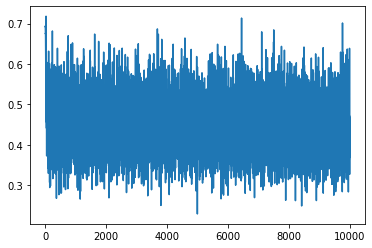

In [ ]:
try:
    loss_list = (torch.stack(loss_list))
except:
    pass
print(loss_list.mean(), loss_list.std())
import matplotlib.pyplot as plt
plt.plot(loss_list.tolist())

In [ ]:
import torch.nn as nn
import copy

self = student 
samples = self.buffer.sample()

policy_network = StudentNetwork(in_dim=self.vae_wrapper.state_dim, out_dim=self.vae_wrapper.action_dim, width=config["MLP_WIDTHS"])
self.policy_network = policy_network.to(self.device)

state = torch.FloatTensor(samples["state"]).to(self.device)
action = torch.LongTensor(samples["action"]).to(self.device)

latents = self.vae_wrapper.predict_latent(samples).detach()

# phase 3. obs_to_latent  MSE loss
obs_to_latent_rep = self.phase3_obs_to_latent_encoder(state)
mse_loss = nn.MSELoss()(obs_to_latent_rep, latents)


# phase 1. policy loss
masked_latents = copy.deepcopy(latents)
#if len(self.masked_states)>0:
#    masked_latents[:, self.masked_states] = 0

#causal_rep = self.causal_features_encoder(masked_latents)  # need this encoder: S -> rep
#qvalues = self.policy_network(causal_rep) # need this encoder:  rep -> A
qvalues = self.policy_network(latents) # need this encoder:  rep -> A

ce_loss = nn.CrossEntropyLoss()(qvalues, action)


policy_loss = ce_loss 
self.policy_opt.zero_grad()
policy_loss.backward()
self.policy_opt.step()


obs_to_latent_loss = mse_loss
self.obs_to_latent_opt.zero_grad()
obs_to_latent_loss.backward()
self.obs_to_latent_opt.step()
        

In [ ]:
config['METHOD'] = "iVAE_IRM"

#for traj_num in [1, 2, 4, 8, 16, 32, 64, 100]:
if True:
    traj_num = 20

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "FINAL_ivaeIRMStudent_replicatedata34_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** train student *****")
            student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1
            )

            #break
            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample
            )

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

Config: {'ENV': 'CartPole-v1', 'ALG': 'FINAL_ivaeIRMStudent_replicatedata34_trajnum20', 'NUM_TRAJS_GIVEN': 20, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 20, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 15, 'BATCH_SIZE': 64, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 10000, 'PHASE2_SAMPLES': 50000, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 4, 'l2_regularizer_weight': 0.001, 'penalty_anneal_iters': 5000, 'penalty_weight': 10000}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 1 out of 15

***** make student *****
state_dim 8
use both actions and env as aux variables
epoch 9900/10000 	loss: -5.627985000610352

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.




***** train student *****
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-192-ad137197ec77>", line 69, in <module>
    student.train(num_updates=config["NUM_STEPS_TRAIN"])
  File "/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/student/vae_irm_student.py", line 167, in train
    for update_index in (range(num_updates)):
  File "/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/student/vae_irm_student.py", line 189, in _update_networks
  File "/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/student/vae_irm_student.py", line 224, in _compute_loss
    #qvalues = self.policy_network(causal_rep) # need this encoder:  rep -> A
  Fil

RuntimeError: ignored

In [ ]:
self = student
state = self.env.reset()
state_env = env_wrapper_out_of_sample._get_obs(state)

state = state_env

inferred_latent = self.phase3_obs_to_latent_encoder(torch.FloatTensor(state).to(self.device))
if len(self.masked_states)>0:
    inferred_latent[self.masked_states] = 0 # added this line!
inferred_latent = inferred_latent.detach()
causal_rep = self.causal_features_encoder(inferred_latent)  # need this encoder: S -> rep

action = self.policy_network(causal_rep).argmax()
action = action.detach().cpu().numpy()

# *** *core* *** generate expert_traj_i 

In [ ]:



def get_train_spurcorr_expert_trajs(datafile_name, env_name,  _noise = 0.001,  num_envs = 2):

    from tqdm import tqdm 
    import numpy as np

    def generate_spurcorr_obs(observations, _mult_factor, _noise = 0.001, _idx = 0):
        noise_dims = len(_mult_factor)
        #obs_noise = np.zeros_like(observations)
        #obs_noise[-noise_dims:] = np.random.randn(noise_dims) * _noise
        spur_corr = np.matmul(observations[-noise_dims:], _mult_factor)
        #obs = np.concatenate([observations + obs_noise, spur_corr, [_idx]])
        obs = np.concatenate([observations , spur_corr + np.random.randn(noise_dims) * _noise, [_idx]])
        return obs

    raw = np.load(datafile_name, allow_pickle = True)#[()]#["trajs"]

    obs_dim = len(raw['obs'][0])
    obs_num = len(raw['obs'])

    for expert_num in range(num_envs):
        # print(_mult_factor_multipliers[expert_num])
            
        obs_new = np.zeros(shape = (obs_num, obs_dim *2))

        #_mult_factor = np.diag(np.ones(obs_dim-1)) * _mult_factor_multipliers[expert_num]
        if expert_num ==0:
            _mult_factor = np.diag(np.ones(obs_dim-1))
        elif expert_num ==1:
            _mult_factor = np.ones((obs_dim-1, obs_dim-1)) + np.diag(np.ones(obs_dim-1))


        for i in tqdm(range(obs_num)):
            obs_new[i] = generate_spurcorr_obs(raw['obs'][i], _mult_factor, _noise = 0.001, _idx = expert_num)


        start_index = np.where(raw['episode_starts'] == 1)[0]

        data_block = []
        for i in range(len(start_index)-1):
            slice_idx = np.arange(start_index[i], start_index[i+1])

            obs = obs_new[slice_idx]
            actions = raw['actions'][slice_idx]

            data_list = []
            for j in range(len(slice_idx)):
                data_list.append( (obs[j], actions[j][0], expert_num) )

            data_block.append(data_list)

        data_generated = {'trajs': data_block}  


        isExist = os.path.exists("./volume/" + env_name)
        if not isExist:
            # Create a new directory because it does not exist 
            os.makedirs("./volume/" + env_name)
            print("The new directory for {} is created!".format(env_name))


        np.save("./volume/" + env_name + '/expert_trajs_' + str(expert_num) + '.npy', data_generated)
        print("\n{} saved!".format("./volume/" + env_name + '/expert_trajs_' + str(expert_num) + '.npy'))
        
    #return data_generated

In [ ]:
np.ones((obs_dim-1, obs_dim-1)) + np.diag(np.ones(obs_dim-1))

array([[2., 1., 1.],
       [1., 2., 1.],
       [1., 1., 2.]])

In [ ]:
import os
os.getcwd()

raw = np.load(datafile_name, allow_pickle = True)
obs_dim = len(raw['obs'][0])
obs_num = len(raw['obs'])

(raw['episode_starts'] == 1).sum()

1000

In [ ]:
#datafile_name = "expert_lunarlander_timesteps2e5_episodes10.npz"
#datafile_name = 'expert_cartpole_timesteps2e5_episodes10.npz'
#datafile_name = './contrib/expert_replicate/' + 'expert_cartpole_dqn_replicate_episodes1000.npz'
datafile_name = './contrib/expert_replicate/' + 'expert_lunarlander_ppo2_replicate_episodes1000.npz'



env_name = 'LunarLander-v2'
#env_name = 'CartPole-v1'

get_train_spurcorr_expert_trajs(datafile_name, env_name = env_name,  _noise = 0.001, num_envs = 2)



  0%|          | 124/902005 [00:05<11:20:06, 22.10it/s]

KeyboardInterrupt: ignored

In [ ]:
data1 = np.load("./volume/CartPole-v1/expert_trajs_1.npy", allow_pickle = True)#[()]#["trajs"]
for key in data1[()]:
  print(key)

trajs
